In [1]:
import numpy as np
import control
import matplotlib.pyplot as plt

# Open-loop inverted pendulum

In [2]:
# create the system using state variable (state-space) representation

g = 9.8 # m/s^2
l = 0.5 # m

A = [[0, 1],
     [g/l, 0]]

B = [[0],
     [-1/l]]

C = [[1, 0]]

D = [[0]]

sys = control.StateSpace(A,B,C,D)

Text(0, 0.5, 'Angle (rad)')

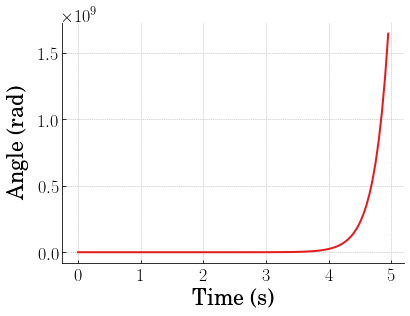

In [3]:
time = np.arange(0,5,0.05)
x0=[1,0]

T, x_out = control.initial_response(sys,time,X0=x0,squeeze=True)

plt.plot(T,x_out)
plt.xlabel('Time (s)', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Angle (rad)', fontsize=22, weight='bold', labelpad=10)
# plt.ylim(-0.01,2*np.pi)

Remember linearized EOMs are only accurate near the states the were linearized around.
Because the inverted pendulum dynamics were linearized, this isn't how the system would actually respond (with the system accelerating towards infinite angle), but the system ***is*** unstable.

# Pole-placement for inverted pendulum

For us to perform pole placement, we need to solve for the K values that "change" the system to have poles at where we want. In this example we place the poles so that $\omega_n=10$ and $\zeta=0.8$.

In [4]:
wn=10
zeta=0.8

# we had to solve the pole-placement problem by hand first to figure out what gains (K) we needed
K_pole_placement = [[-l*wn**2-g,-2*zeta*wn*l]]

K_pole_placement = np.asarray(K_pole_placement)

# redefine the system as x_dot = (A-BK)x

# the new A matrix is
A_pole_placement = A-B@K_pole_placement

# the new B matrix is
B_pole_placement = [[0],
                    [0]]

sys_pole_placement = control.StateSpace(A_pole_placement,B_pole_placement,C,D)

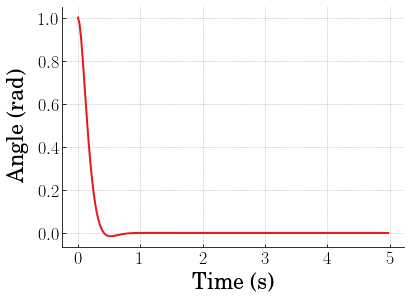

In [5]:
time = np.arange(0,5,0.025)
x0=[1,0]

T, x_out = control.initial_response(sys_pole_placement,time,X0=x0,squeeze=True)

plt.xlabel('Time (s)', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Angle (rad)', fontsize=22, weight='bold', labelpad=10)
plt.plot(T,x_out)


# LQR design

Solving the LQR problem will design the K values for full-state feedback that minimizes a performance metric. We don't need to manually solve for the K ourselves. We could spend a lot of time designing the $\mathbf{Q}$ matrix and $R$ weighting factor, but we don't have to.

In [18]:
# Decide on weighting matrices for LQR
# for simplicity, we'll just use diagonal ones matrices

Q = [[1, 0],
     [0, 1]]

# system is single input, so R is a scalar
R = [[1]]

K_lqr, S, E = control.lqr(A,B,Q,R)

print(K_lqr[0,0])

-19.650888284819807


In [7]:
# redefine the system as x_dot = (A-BK)x

# the new A matrix is
A_lqr = A-B@K_lqr # the @ is for matrix multiplication

# the new B matrix is
B_lqr = [[0],
         [0]]

sys_lqr = control.StateSpace(A_lqr,B_lqr,C,D)

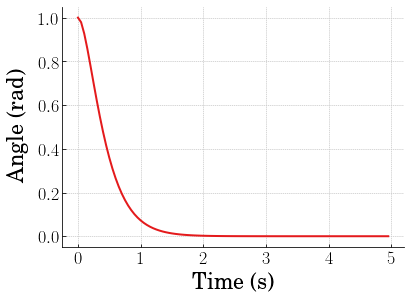

In [12]:
time = np.arange(0,5,0.05)
x0=[1,0]

T, x_out, states = control.initial_response(sys_lqr,time,X0=x0,squeeze=True, return_x=True)

plt.xlabel('Time (s)', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Angle (rad)', fontsize=22, weight='bold', labelpad=10)
plt.plot(T,x_out)

So if all we cared about was stabilizing the system, we could quickly design an LQR controller that performed the desired goal. We could also plot the input $u=-K\mathbf{x}$. This would be important for tuning the $R$ weighting factor if it were important to keep the input within certain bounds.

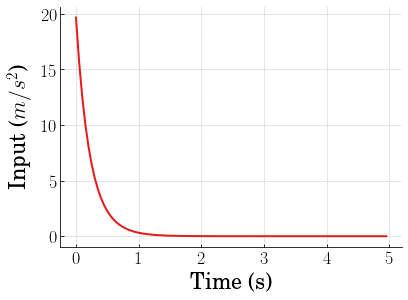

In [21]:
u_lqr = -K_lqr[0,0]*states[0,:] - K_lqr[0,1]*states[1,:]

plt.xlabel('Time (s)', fontsize=22, weight='bold', labelpad=5)
plt.ylabel(r'Input ($m/s^2$)', fontsize=22, weight='bold', labelpad=10)
plt.plot(T, u_lqr)